# Overlap

Two types of plots are made in this figure:

1. UpSetPlot

Two UpSetPlots are created showing the overlap in spectrum_ids between spectra which were correctly predicted by the de novo tool and incorrectly predicted

2. Heatmap

The pairwise overlap is computed between two tools and shown in a heatmap. This will show the redundancy.

In [116]:
import os
from upsetplot import from_contents, plot
from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm

import numpy as np
from itertools import permutations, combinations

# 1. Load the data

In [2]:
root_results_dn = '/public/compomics3/Sam/PXD028735/QExactive/denovo_output'
root_mgf = '/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
root_results_db = '/public/compomics3/Sam/PXD028735/QExactive/search_results/identification'
run_names = [
    'LFQ_Orbitrap_DDA_Ecoli_01',
    'LFQ_Orbitrap_DDA_Human_01',
    'LFQ_Orbitrap_DDA_QC_01',
    'LFQ_Orbitrap_DDA_Yeast_01'
]

engine_names = [
    'adanovo',
    'pihelixnovo',
    'piprimenovo',
    'casanovo',
    'instanovo',
    'contranovo',
    'novob',
    'pepnet',
]

runs = {}
for run_name in run_names:
    print(f"Run: {run_name}")
    run = Run(run_name)

    mgf_path = os.path.join(root_mgf, run_name + '.mgf')

    parser = DenovoEngineConverter.select('sage')
    psmlist_gt = parser.parse(
        result_path=os.path.join(root_results_db, run_name + '.sage.tsv'),
        mgf_path=mgf_path
    )
    run.load_data(
        psmlist=psmlist_gt.get_rank1_psms(),
        score_names=[],
        is_ground_truth=True
    )

    for engine_name in engine_names:
        print(f'loading {engine_name}')
        parser = DenovoEngineConverter.select(engine_name)
        psmlist_denovo = parser.parse(
            result_path=os.path.join(root_results_dn, engine_name, run_name + f'.{engine_name}.some_extension'),
            mgf_path=mgf_path
        )
        run.load_data(
            psmlist=psmlist_denovo,
            score_names=[],
            is_ground_truth=False
        )
    
    runs[run_name] = run

Run: LFQ_Orbitrap_DDA_Ecoli_01


100%|██████████| 24285/24285 [00:01<00:00, 18826.51it/s]


loading adanovo


100%|██████████| 61843/61843 [00:01<00:00, 46738.41it/s]


loading pihelixnovo


100%|██████████| 61955/61955 [00:02<00:00, 29636.83it/s] 


loading piprimenovo


100%|██████████| 58682/58682 [00:02<00:00, 27048.64it/s] 


loading casanovo


100%|██████████| 61876/61876 [00:01<00:00, 44730.59it/s]


loading instanovo


100%|██████████| 61562/61562 [00:02<00:00, 24222.36it/s] 


loading contranovo


100%|██████████| 30999/30999 [00:00<00:00, 48525.50it/s]


loading novob


100%|██████████| 61479/61479 [00:00<00:00, 89363.57it/s] 


loading pepnet


100%|██████████| 62560/62560 [00:01<00:00, 52304.28it/s]


Run: LFQ_Orbitrap_DDA_Human_01


100%|██████████| 90817/90817 [00:07<00:00, 12392.76it/s]


loading adanovo


100%|██████████| 115178/115178 [00:11<00:00, 9622.63it/s] 


loading pihelixnovo


100%|██████████| 115417/115417 [00:09<00:00, 11814.27it/s]


loading piprimenovo


100%|██████████| 111287/111287 [00:02<00:00, 46089.59it/s]


loading casanovo


100%|██████████| 115362/115362 [00:04<00:00, 23937.51it/s]


loading instanovo


100%|██████████| 114725/114725 [00:02<00:00, 46232.81it/s]


loading contranovo


100%|██████████| 57640/57640 [00:02<00:00, 23350.37it/s]


loading novob


100%|██████████| 114067/114067 [00:01<00:00, 72438.45it/s]


loading pepnet


100%|██████████| 118245/118245 [00:03<00:00, 38339.48it/s]


Run: LFQ_Orbitrap_DDA_QC_01


100%|██████████| 83941/83941 [00:01<00:00, 62997.86it/s]


loading adanovo


100%|██████████| 107088/107088 [00:02<00:00, 39529.36it/s]


loading pihelixnovo


100%|██████████| 107182/107182 [00:01<00:00, 69952.85it/s]


loading piprimenovo


100%|██████████| 103511/103511 [00:01<00:00, 75760.95it/s]


loading casanovo


100%|██████████| 107203/107203 [00:02<00:00, 39360.53it/s]


loading instanovo


100%|██████████| 106604/106604 [00:01<00:00, 77732.21it/s]


loading contranovo


100%|██████████| 53533/53533 [00:01<00:00, 35578.91it/s]


loading novob


100%|██████████| 106078/106078 [00:01<00:00, 80618.81it/s]


loading pepnet


100%|██████████| 109340/109340 [00:02<00:00, 37456.69it/s]


Run: LFQ_Orbitrap_DDA_Yeast_01


100%|██████████| 67111/67111 [00:00<00:00, 70563.16it/s]


loading adanovo


100%|██████████| 102427/102427 [00:10<00:00, 10018.76it/s]


loading pihelixnovo


100%|██████████| 102483/102483 [00:01<00:00, 95011.21it/s]


loading piprimenovo


100%|██████████| 96975/96975 [00:00<00:00, 99253.35it/s] 


loading casanovo


100%|██████████| 102518/102518 [00:02<00:00, 50016.59it/s]


loading instanovo


100%|██████████| 101883/101883 [00:10<00:00, 9746.22it/s] 


loading contranovo


100%|██████████| 51215/51215 [00:00<00:00, 51786.51it/s]


loading novob


100%|██████████| 101183/101183 [00:01<00:00, 99812.55it/s]


loading pepnet


100%|██████████| 103785/103785 [00:02<00:00, 50641.92it/s]


In [3]:
for run in runs.values():
    for spectrum in run.spectra.values():
        spectrum.compare_gt(
            'sage',
            ignore_score=True
        )

## 2. Create spectrum_id lists

For correct predictions, spectrum-ids is enough.

For false predictions, peptidoforms need to be provided aswell.

In [4]:
denovo_engines = ['casanovo', 'novob', 'instanovo', 'pepnet', 'contranovo', 'pi-PrimeNovo', 'AdaNovo', 'pi-HelixNovo']

In [82]:
correct_by_engine = {engine: [] for engine in denovo_engines}
for run_name, run in runs.items():
    for engine in denovo_engines:
        run_engine = run.get_common_spectra(engines=[engine])
        for specid, spectrum in run_engine.spectra.items():
            psm = spectrum.get_psms_by_engine(engine)[0]
            if psm.evaluation['sage'].error_type=='match':
                correct_by_engine[engine].append(
                    f'{run_name}_{specid}_{psm.peptidoform.proforma}'
                )

false_by_engine = {engine: [] for engine in denovo_engines}
for run_name, run in runs.items():
    for engine in denovo_engines:
        run_engine = run.get_common_spectra(engines=[engine])
        for specid, spectrum in run_engine.spectra.items():
            psm = spectrum.get_psms_by_engine(engine)[0]
            if psm.evaluation['sage'].error_type!='match':
                false_by_engine[engine].append(
                    f'{run_name}_{specid}_{psm.peptidoform.proforma}'
                )

all_by_engine = {engine: [] for engine in denovo_engines}
for run_name, run in runs.items():
    for engine in denovo_engines:
        run_engine = run.get_common_spectra(engines=[engine])
        for specid, spectrum in run_engine.spectra.items():
            psm = spectrum.get_psms_by_engine(engine)[0]
            all_by_engine[engine].append(
                f'{run_name}_{specid}_{psm.peptidoform.proforma}'
            )

In [83]:
upset_data_correct = from_contents(correct_by_engine)
upset_data_false = from_contents(false_by_engine)

## 2.1. Correct spectra

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

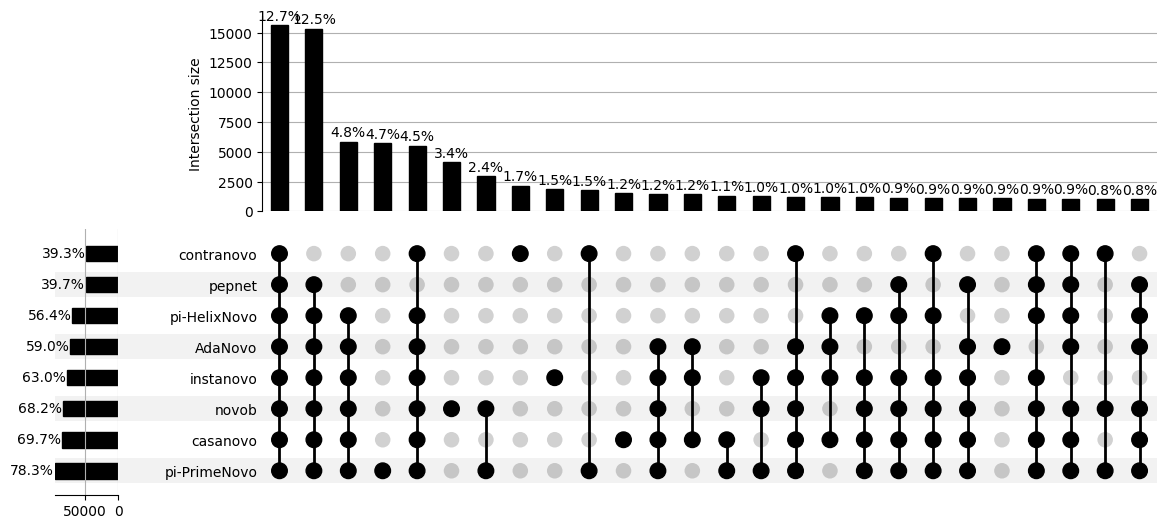

In [84]:
plot(upset_data_correct, sort_by='cardinality', show_percentages=True, min_subset_size=1000)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

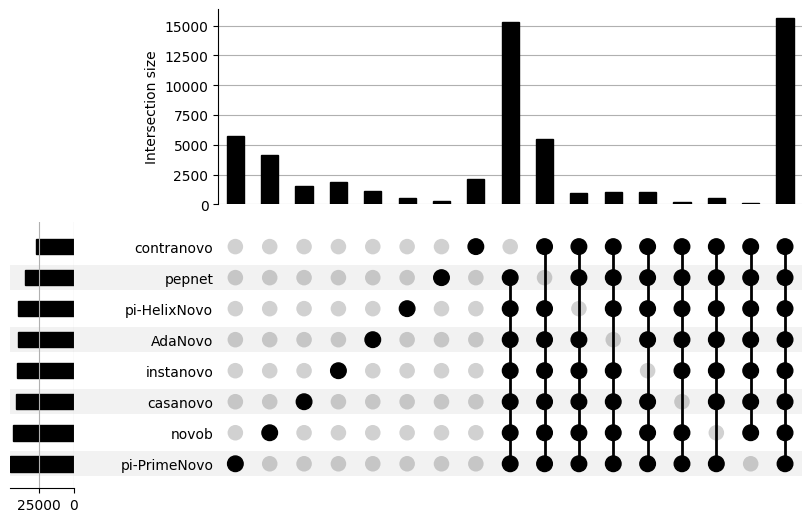

In [85]:
plot(upset_data_correct.loc[
    (upset_data_correct.reset_index().sum(axis=1)>6).to_numpy() |
    (upset_data_correct.reset_index().sum(axis=1)==1).to_numpy()
])

## 2.2 False spectra

Necessary ?

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

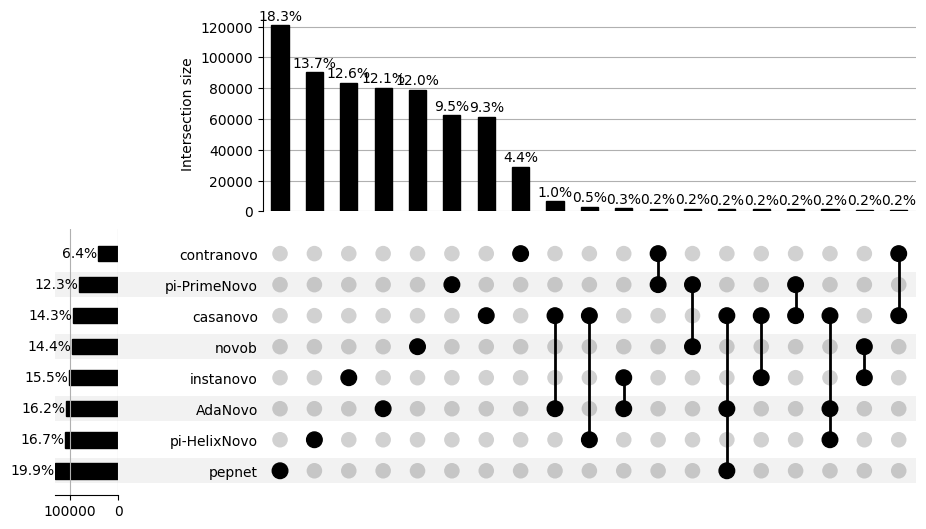

In [86]:
plot(upset_data_false, sort_by='cardinality', show_percentages=True, min_subset_size=1000)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

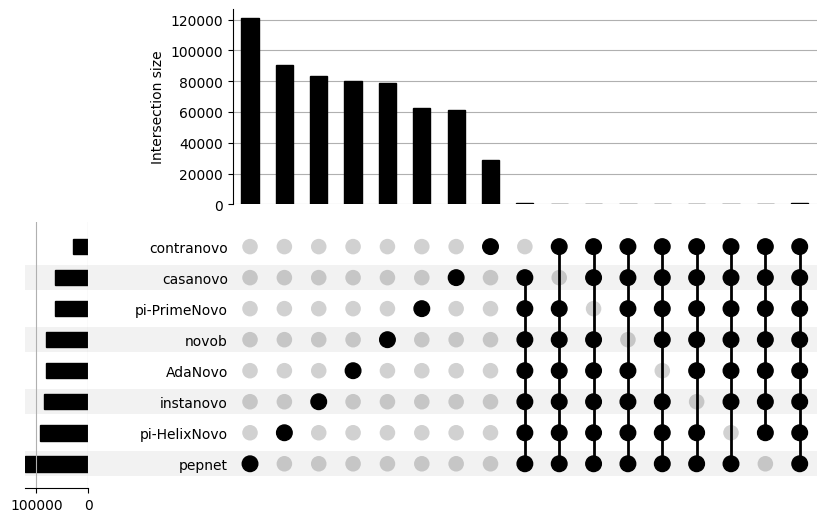

In [87]:
plot(upset_data_false.loc[
    (upset_data_false.reset_index().sum(axis=1)>6).to_numpy() |
    (upset_data_false.reset_index().sum(axis=1)==1).to_numpy()
])

In [125]:
common_false_ids = upset_data_false[(upset_data_false.reset_index().sum(axis=1) == 8).to_numpy()]['id'].tolist()

In [126]:
common_false_ids

['LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 controllerNumber=1 scan=68814_IAATIAQIPDQIQK/2',
 'LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 controllerNumber=1 scan=50248_VAAIEGDVIGSYQHQR/2',
 'LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 controllerNumber=1 scan=86781_DVAGYAAGIEFIDR/2',
 'LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 controllerNumber=1 scan=26564_ENTEGEYSSINR/2',
 'LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 controllerNumber=1 scan=39696_ITGVSEEIQTR/2',
 'LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 controllerNumber=1 scan=85939_FNEIGSITETIAAIK/2',
 'LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 controllerNumber=1 scan=73519_NFFEEDQIIR/2',
 'LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 controllerNumber=1 scan=81300_FGGYAESGIIAEITPDK/2',
 'LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 controllerNumber=1 scan=57934_EIANVQDITVR/2',
 'LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 controllerNumber=1 scan=58185_IIVVEDAEPIR/2',
 'LFQ_Orbitrap_DDA_Ecoli_01_controllerType=0 controllerNumber=1 scan=

# 3. Pairwise overlaps Heatmaps

2 heatmaps: Only correct ones and only false ones ?

In [89]:
def get_overlap(list1, list2):
    set_1, set_2 = set(list1), set(list2)
    intersection = set_1.intersection(set_2)

    if len(set_1) == 0:
        overlap_tool_1 = 0
    else:
        overlap_tool_1 = len(intersection) / len(set_1)
    if len(set_2) == 0:
        overlap_tool_2 = 0
    else:
        overlap_tool_2 = len(intersection) / len(set_2)

    return overlap_tool_1, overlap_tool_2

In [111]:
def get_overlap_matrix(dict_of_lists, denovo_engines):
    overlap_matrix = np.ones((len(denovo_engines), len(denovo_engines)))

    for (engine_1, engine_2) in combinations(denovo_engines, 2):
        i = denovo_engines.index(engine_1)
        j = denovo_engines.index(engine_2)
        overlap_1, overlap_2 = get_overlap(
            dict_of_lists[engine_1],
            dict_of_lists[engine_2]
        )
        overlap_matrix[i, j] = overlap_1
        overlap_matrix[j, i] = overlap_2
    return overlap_matrix

In [112]:
all_overlap_matrix = get_overlap_matrix(all_by_engine, denovo_engines=denovo_engines)
correct_overlap_matrix = get_overlap_matrix(correct_by_engine, denovo_engines=denovo_engines)
false_overlap_matrix = get_overlap_matrix(false_by_engine, denovo_engines=denovo_engines)

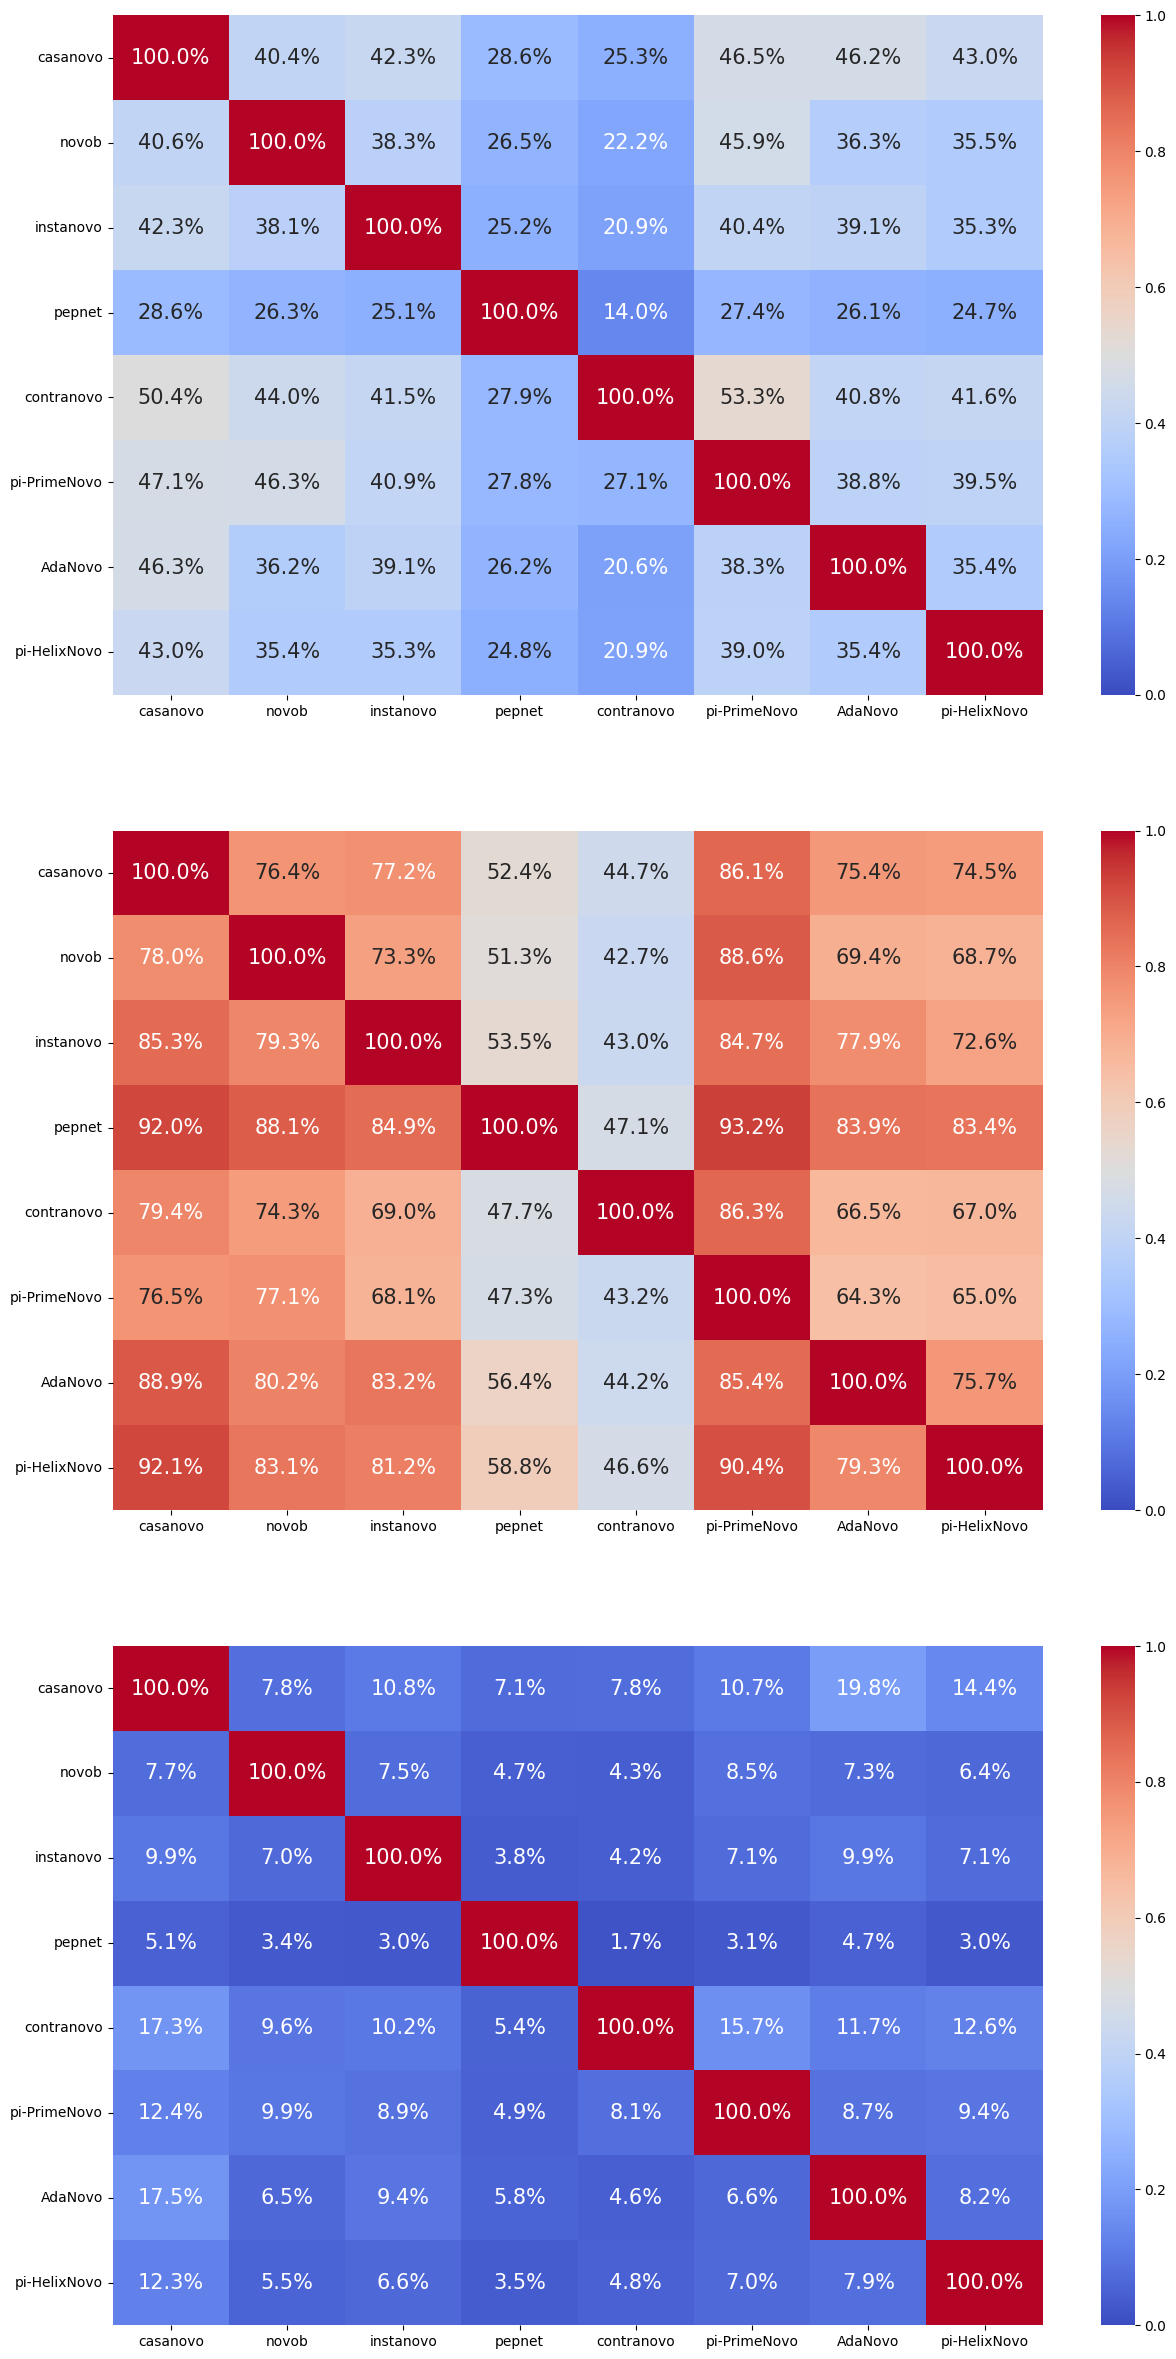

In [120]:
fig, ax = plt.subplots(3,1, figsize=(15,30))
for i, om in enumerate([all_overlap_matrix, correct_overlap_matrix, false_overlap_matrix]):
    sns.heatmap(
        om,
        annot=True,
        cmap="coolwarm",
        xticklabels=denovo_engines,
        yticklabels=denovo_engines,
        ax=ax[i],
        vmin=0,
        vmax=1,
        fmt=".1%",
        annot_kws={"size": 15}
    )

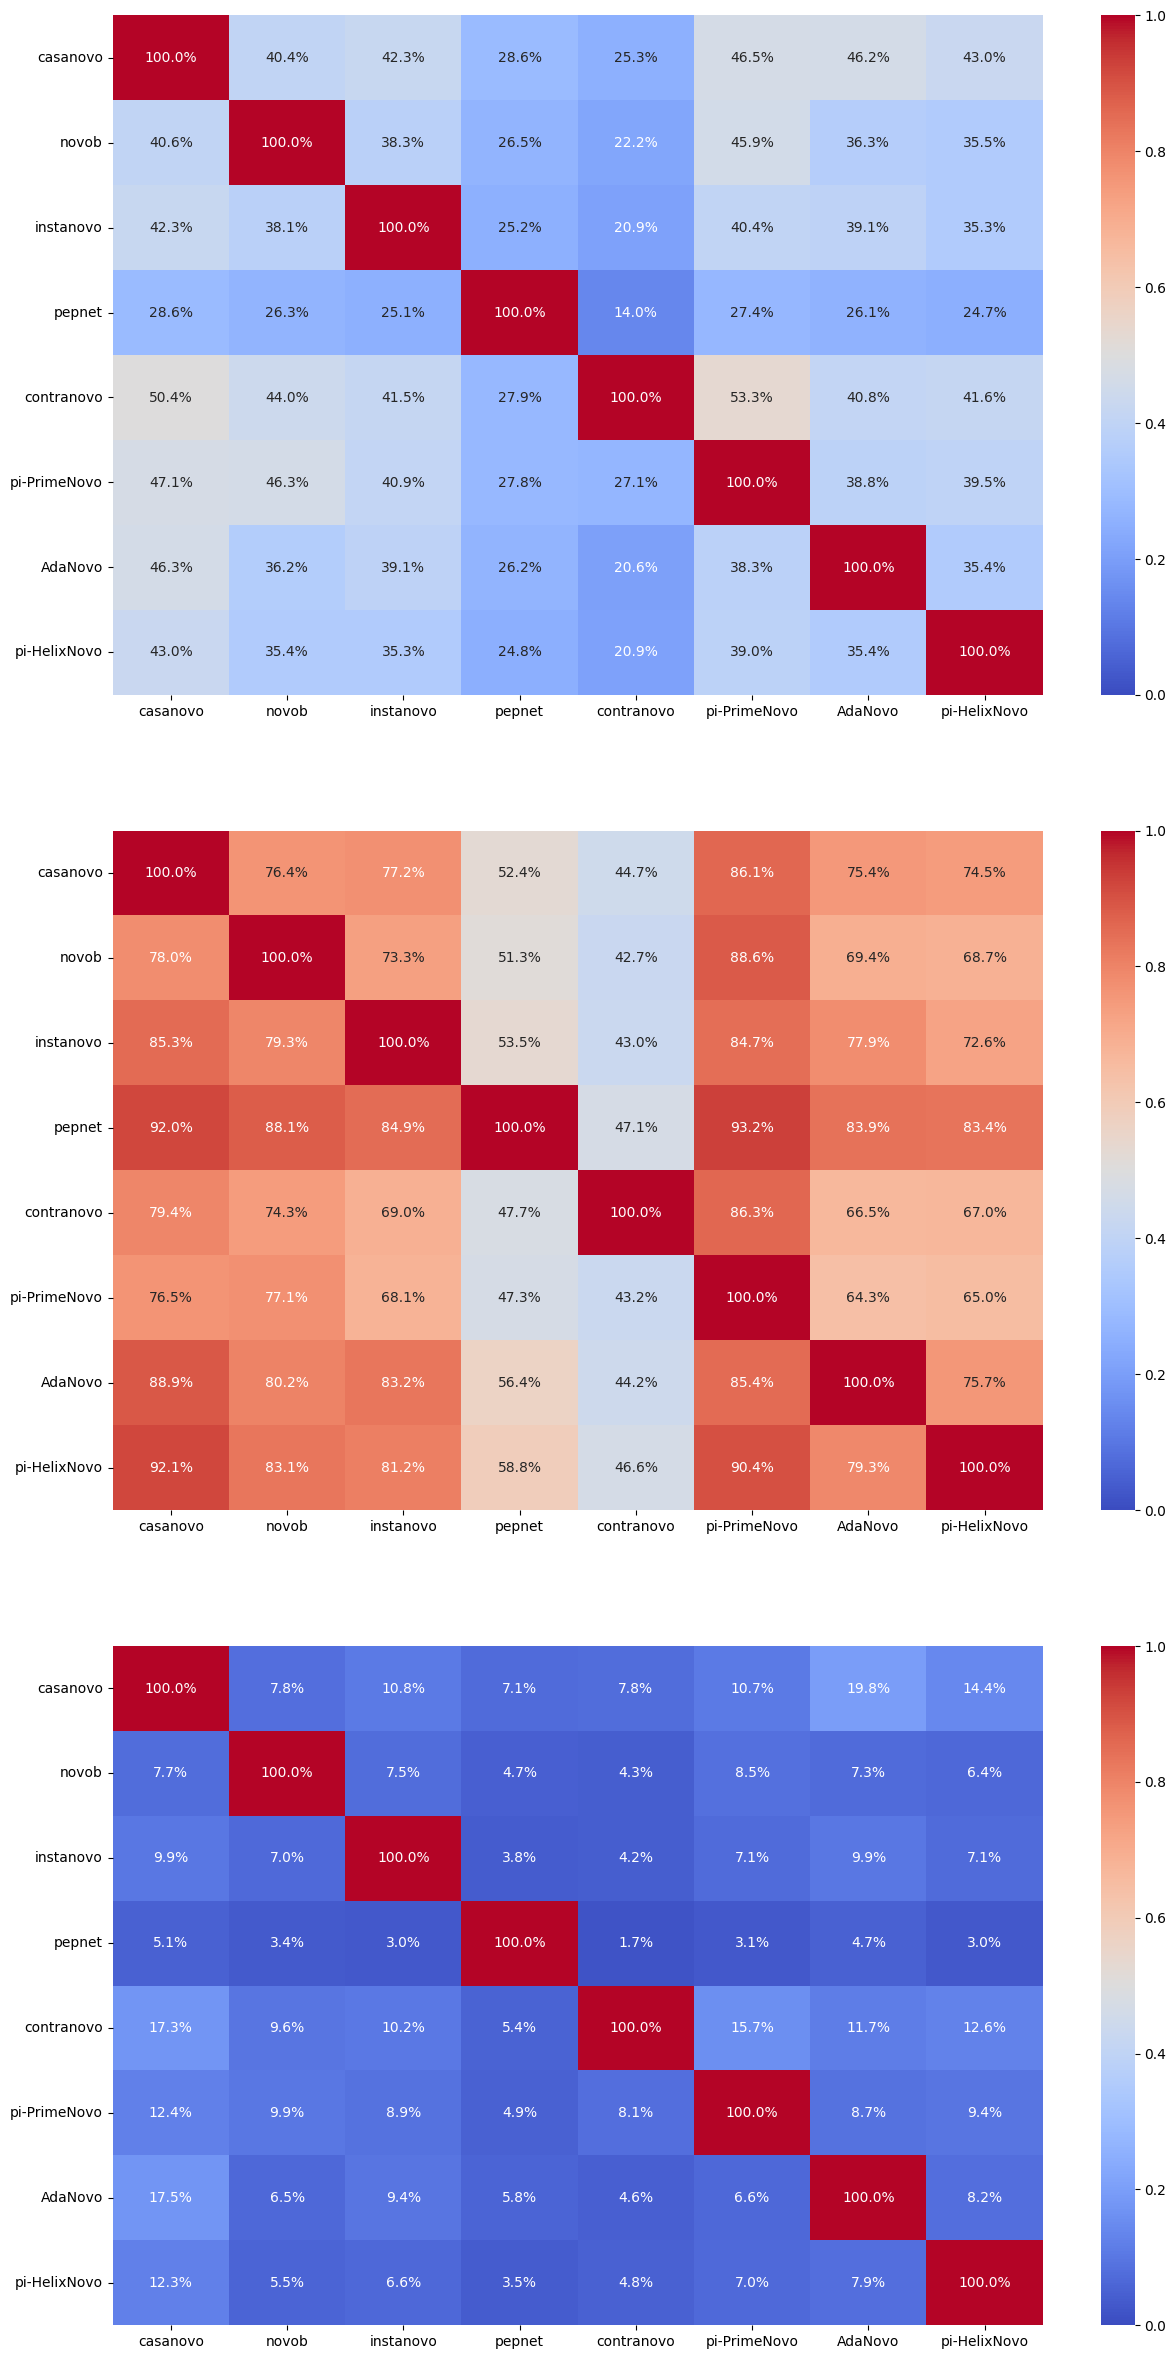

In [119]:
fig, ax = plt.subplots(3,1, figsize=(15,30))
for i, om in enumerate([all_overlap_matrix, correct_overlap_matrix, false_overlap_matrix]):
    sns.heatmap(
        om,
        annot=True,
        cmap="coolwarm",
        xticklabels=denovo_engines,
        yticklabels=denovo_engines,
        ax=ax[i],
        vmin=0,
        vmax=1,
        fmt=".1%",
        annot_kws={"size": 15}
    )